# Versión con Ajuste Fino (Fine-Tuning) para el modelo multi-salida

Esta versión del código implementa el ajuste fino descongelando las últimas capas del modelo base EfficientNetB0 para mejorar la adaptación a tu conjunto de datos.

!pip install tensorflow

In [1]:
# Importar librerías necesarias
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

2025-05-10 19:15:55.108748: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 19:15:55.123840: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 19:15:55.217483: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 19:15:55.300101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746918955.396588   26192 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746918955.43

In [2]:
# =============================================
# CONFIGURACIÓN
# =============================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 30  # Entrenamiento inicial con base congelada
EPOCHS_FINE_TUNE = 30  # Entrenamiento con ajuste fino
LEARNING_RATE_INITIAL = 5e-5  # Ajuste de tasa de aprendizaje inicial
LEARNING_RATE_FINE_TUNE = 5e-6  # Ajuste de tasa de aprendizaje para fine-tuning
BASE_MODEL = 'EfficientNetB0'

In [3]:
# =============================================
# DICCIONARIOS DE MAPEO
# =============================================
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

In [4]:
# =============================================
# CARGA DE DATOS
# =============================================
def load_and_prepare_data(split_dir):
    """Carga imágenes y etiquetas para un conjunto (train/val/test)"""
    df = pd.read_csv(f'{split_dir}/{split_dir.split("/")[-1]}_set.csv', sep='|')
    # Convertir strings de listas a listas reales
    for col in ['dannos', 'partes', 'sugerencias']:
        df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    return df

# Cargar todos los conjuntos
train_df = load_and_prepare_data('data/fotos_siniestros/train')
val_df = load_and_prepare_data('data/fotos_siniestros/val')
test_df = load_and_prepare_data('data/fotos_siniestros/test')

In [5]:
# =============================================
# PREPARACIÓN DE ETIQUETAS
# =============================================
mlb_partes = MultiLabelBinarizer()
mlb_dannos = MultiLabelBinarizer()
mlb_sugerencias = MultiLabelBinarizer()

y_train_partes = mlb_partes.fit_transform(train_df['partes'])
y_train_dannos = mlb_dannos.fit_transform(train_df['dannos'])
y_train_sugerencias = mlb_sugerencias.fit_transform(train_df['sugerencias'])

y_val_partes = mlb_partes.transform(val_df['partes'])
y_val_dannos = mlb_dannos.transform(val_df['dannos'])
y_val_sugerencias = mlb_sugerencias.transform(val_df['sugerencias'])

# Guardar MultiLabelBinarizer objects para uso posterior
import pickle
with open("mlb_partes.pkl", "wb") as f:
    pickle.dump(mlb_partes, f)
with open("mlb_dannos.pkl", "wb") as f:
    pickle.dump(mlb_dannos, f)
with open("mlb_sugerencias.pkl", "wb") as f:
    pickle.dump(mlb_sugerencias, f)
print("MultiLabelBinarizer objects saved.")

MultiLabelBinarizer objects saved.


In [6]:
# =============================================
# GENERADOR DE DATOS
# =============================================
class MultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mlb_partes, mlb_dannos, mlb_sugerencias, 
                 batch_size=32, img_size=(224, 224), shuffle=True, augmentation=None):
        self.df = df
        self.img_dir = img_dir
        self.mlb_partes = mlb_partes
        self.mlb_dannos = mlb_dannos
        self.mlb_sugerencias = mlb_sugerencias
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.empty((len(batch_df), *self.img_size, 3))
        y_partes = []
        y_dannos = []
        y_sugerencias = []
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.img_dir, row['Imagen'])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            
            if self.augmentation:
                img_array = self.augmentation.random_transform(img_array)
                
            img_array = applications.efficientnet.preprocess_input(img_array)
            X[i] = img_array
            
            y_partes.append(row['partes'])
            y_dannos.append(row['dannos'])
            y_sugerencias.append(row['sugerencias'])
        
        y_partes = np.array(self.mlb_partes.transform(y_partes), dtype='float32')
        y_dannos = np.array(self.mlb_dannos.transform(y_dannos), dtype='float32')
        y_sugerencias = np.array(self.mlb_sugerencias.transform(y_sugerencias), dtype='float32')
        
        return X, {'partes': y_partes, 'dannos': y_dannos, 'sugerencias': y_sugerencias}
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

IMG_DIR = '../data/fotos_siniestros/'

train_generator = MultiLabelDataGenerator(
    train_df, 
    IMG_DIR, 
    mlb_partes, 
    mlb_dannos, 
    mlb_sugerencias,
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augmentation=train_datagen
)

val_generator = MultiLabelDataGenerator(
    val_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

test_generator = MultiLabelDataGenerator(
    test_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

In [ ]:
# =============================================
# CONSTRUCCIÓN DEL MODELO CON AJUSTE FINO Y MEJORAS
# =============================================
# Last Execution 7:40:54 PM
# Execution Time 24m 21.9s
# Overhead Time 104ms
# Render Times
# VS Code Builtin Notebook Output Renderer 117ms

def build_multi_output_model_fine_tuning(input_shape, num_partes, num_dannos, num_sugerencias, base_model_name='EfficientNetB0'):
    if base_model_name == 'EfficientNetB0':
        base_model = applications.EfficientNetB0(
            include_top=False, 
            weights='imagenet', 
            input_shape=input_shape
        )
    elif base_model_name == 'ResNet50':
        base_model = applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape
        )
    else:
        raise ValueError(f"Modelo base no soportado: {base_model_name}")

    # Congelar todas las capas inicialmente
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)  # Reducido dropout para menos regularización

    output_partes = layers.Dense(num_partes, activation='sigmoid', name='partes')(x)
    output_dannos = layers.Dense(num_dannos, activation='sigmoid', name='dannos')(x)
    output_sugerencias = layers.Dense(num_sugerencias, activation='sigmoid', name='sugerencias')(x)

    model = models.Model(
        inputs=inputs,
        outputs=[output_partes, output_dannos, output_sugerencias]
    )

    return model

# Construir modelo
model = build_multi_output_model_fine_tuning(
    input_shape=(*IMG_SIZE, 3),
    num_partes=len(mlb_partes.classes_),
    num_dannos=len(mlb_dannos.classes_),
    num_sugerencias=len(mlb_sugerencias.classes_),
    base_model_name=BASE_MODEL
)

# Compilar para entrenamiento inicial
model.compile(
    optimizer=Adam(learning_rate=5e-5),  # tasa de aprendizaje inicial ajustada
    loss={
        'partes': 'binary_crossentropy',
        'dannos': 'binary_crossentropy',
        'sugerencias': 'binary_crossentropy'
    },
    metrics={
        'partes': 'accuracy',
        'dannos': 'accuracy',
        'sugerencias': 'accuracy'
    }
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_fine_tuning.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento inicial con base congelada
history_initial = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_INITIAL,
    callbacks=[checkpoint, early_stopping],
    class_weight=None,
    verbose=1
)

# Descongelar últimas capas para ajuste fino
base_model = model.layers[1]  # Asumiendo que la segunda capa es el modelo base
base_model.trainable = True

# Congelar todas las capas excepto las últimas 30 (más capas descongeladas)
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar con tasa de aprendizaje menor
model.compile(
    optimizer=Adam(learning_rate=5e-6),  # tasa de aprendizaje para fine-tuning ajustada
    loss={
        'partes': 'binary_crossentropy',
        'dannos': 'binary_crossentropy',
        'sugerencias': 'binary_crossentropy'
    },
    metrics={
        'partes': 'accuracy',
        'dannos': 'accuracy',
        'sugerencias': 'accuracy'
    }
)

# Entrenamiento con ajuste fino
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_FINE_TUNE,
    callbacks=[checkpoint, early_stopping],
    class_weight=None,
    verbose=1
)

# Guardar modelo final
model.save('final_model_fine_tuned_v2.keras')

2025-05-10 19:16:36.288811: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/data/Python/DetectarDannosPartesSugerenciasUsandoMultiplesEtiquetasTF_APIs_1500fotos/.venv-3-11/lib64/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.2710 - dannos_loss: 0.7044 - loss: 2.0749 - partes_accuracy: 0.0384 - partes_loss: 0.7289 - sugerencias_accuracy: 0.6837 - sugerencias_loss: 0.6411
Epoch 1: val_loss improved from inf to 1.69995, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - dannos_accuracy: 0.2714 - dannos_loss: 0.7027 - loss: 2.0710 - partes_accuracy: 0.0387 - partes_loss: 0.7276 - sugerencias_accuracy: 0.6854 - sugerencias_loss: 0.6401 - val_dannos_accuracy: 0.3405 - val_dannos_loss: 0.5544 - val_loss: 1.6999 - val_partes_accuracy: 0.0862 - val_partes_loss: 0.5924 - val_sugerencias_accuracy: 0.7845 - val_sugerencias_loss: 0.5568
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.3076 - dannos_loss: 0.5373 - loss: 1.6308 - partes_accuracy: 0.0755 - partes_loss: 0.5436 - sugerencias_accuracy: 0.8101 - sugerencias_loss: 0.5492
Epoch 2: val_loss improved from 1.69995 to 1.45200, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - dannos_accuracy: 0.3081 - dannos_loss: 0.5369 - loss: 1.6290 - partes_accuracy: 0.0754 - partes_loss: 0.5427 - sugerencias_accuracy: 0.8103 - sugerencias_loss: 0.5487 - val_dannos_accuracy: 0.3879 - val_dannos_loss: 0.4983 - val_loss: 1.4520 - val_partes_accuracy: 0.0991 - val_partes_loss: 0.4564 - val_sugerencias_accuracy: 0.8405 - val_sugerencias_loss: 0.4992
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.3773 - dannos_loss: 0.4925 - loss: 1.4166 - partes_accuracy: 0.0596 - partes_loss: 0.4143 - sugerencias_accuracy: 0.8270 - sugerencias_loss: 0.5091
Epoch 3: val_loss improved from 1.45200 to 1.29543, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - dannos_accuracy: 0.3776 - dannos_loss: 0.4926 - loss: 1.4154 - partes_accuracy: 0.0599 - partes_loss: 0.4135 - sugerencias_accuracy: 0.8275 - sugerencias_loss: 0.5086 - val_dannos_accuracy: 0.4224 - val_dannos_loss: 0.4766 - val_loss: 1.2954 - val_partes_accuracy: 0.1638 - val_partes_loss: 0.3592 - val_sugerencias_accuracy: 0.8578 - val_sugerencias_loss: 0.4611
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.3718 - dannos_loss: 0.4846 - loss: 1.2826 - partes_accuracy: 0.0928 - partes_loss: 0.3220 - sugerencias_accuracy: 0.8608 - sugerencias_loss: 0.4685
Epoch 4: val_loss improved from 1.29543 to 1.19539, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - dannos_accuracy: 0.3723 - dannos_loss: 0.4845 - loss: 1.2817 - partes_accuracy: 0.0933 - partes_loss: 0.3216 - sugerencias_accuracy: 0.8607 - sugerencias_loss: 0.4683 - val_dannos_accuracy: 0.4612 - val_dannos_loss: 0.4624 - val_loss: 1.1954 - val_partes_accuracy: 0.2112 - val_partes_loss: 0.3000 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.4324
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.4280 - dannos_loss: 0.4632 - loss: 1.1769 - partes_accuracy: 0.1369 - partes_loss: 0.2753 - sugerencias_accuracy: 0.8569 - sugerencias_loss: 0.4336
Epoch 5: val_loss improved from 1.19539 to 1.12894, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - dannos_accuracy: 0.4281 - dannos_loss: 0.4631 - loss: 1.1764 - partes_accuracy: 0.1372 - partes_loss: 0.2751 - sugerencias_accuracy: 0.8571 - sugerencias_loss: 0.4334 - val_dannos_accuracy: 0.4957 - val_dannos_loss: 0.4511 - val_loss: 1.1289 - val_partes_accuracy: 0.2672 - val_partes_loss: 0.2647 - val_sugerencias_accuracy: 0.8879 - val_sugerencias_loss: 0.4118
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.4601 - dannos_loss: 0.4597 - loss: 1.1237 - partes_accuracy: 0.1893 - partes_loss: 0.2479 - sugerencias_accuracy: 0.8645 - sugerencias_loss: 0.4161
Epoch 6: val_loss improved from 1.12894 to 1.08956, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - dannos_accuracy: 0.4600 - dannos_loss: 0.4597 - loss: 1.1233 - partes_accuracy: 0.1894 - partes_loss: 0.2477 - sugerencias_accuracy: 0.8645 - sugerencias_loss: 0.4159 - val_dannos_accuracy: 0.5086 - val_dannos_loss: 0.4425 - val_loss: 1.0896 - val_partes_accuracy: 0.2716 - val_partes_loss: 0.2454 - val_sugerencias_accuracy: 0.8922 - val_sugerencias_loss: 0.4007
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.4979 - dannos_loss: 0.4464 - loss: 1.0508 - partes_accuracy: 0.1980 - partes_loss: 0.2312 - sugerencias_accuracy: 0.9002 - sugerencias_loss: 0.3794
Epoch 7: val_loss improved from 1.08956 to 1.06021, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - dannos_accuracy: 0.4969 - dannos_loss: 0.4465 - loss: 1.0515 - partes_accuracy: 0.1985 - partes_loss: 0.2312 - sugerencias_accuracy: 0.8996 - sugerencias_loss: 0.3799 - val_dannos_accuracy: 0.5043 - val_dannos_loss: 0.4341 - val_loss: 1.0602 - val_partes_accuracy: 0.2931 - val_partes_loss: 0.2327 - val_sugerencias_accuracy: 0.8879 - val_sugerencias_loss: 0.3923
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5083 - dannos_loss: 0.4370 - loss: 1.0404 - partes_accuracy: 0.2180 - partes_loss: 0.2234 - sugerencias_accuracy: 0.8739 - sugerencias_loss: 0.3795
Epoch 8: val_loss improved from 1.06021 to 1.03985, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - dannos_accuracy: 0.5085 - dannos_loss: 0.4371 - loss: 1.0405 - partes_accuracy: 0.2181 - partes_loss: 0.2234 - sugerencias_accuracy: 0.8739 - sugerencias_loss: 0.3795 - val_dannos_accuracy: 0.5172 - val_dannos_loss: 0.4284 - val_loss: 1.0399 - val_partes_accuracy: 0.2845 - val_partes_loss: 0.2234 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.3862
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.4927 - dannos_loss: 0.4373 - loss: 1.0401 - partes_accuracy: 0.2408 - partes_loss: 0.2181 - sugerencias_accuracy: 0.8682 - sugerencias_loss: 0.3844
Epoch 9: val_loss improved from 1.03985 to 1.02175, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.4932 - dannos_loss: 0.4372 - loss: 1.0394 - partes_accuracy: 0.2409 - partes_loss: 0.2181 - sugerencias_accuracy: 0.8680 - sugerencias_loss: 0.3840 - val_dannos_accuracy: 0.5345 - val_dannos_loss: 0.4216 - val_loss: 1.0217 - val_partes_accuracy: 0.3147 - val_partes_loss: 0.2168 - val_sugerencias_accuracy: 0.8836 - val_sugerencias_loss: 0.3819
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5095 - dannos_loss: 0.4331 - loss: 1.0281 - partes_accuracy: 0.2409 - partes_loss: 0.2116 - sugerencias_accuracy: 0.8592 - sugerencias_loss: 0.3817
Epoch 10: val_loss improved from 1.02175 to 1.01158, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - dannos_accuracy: 0.5095 - dannos_loss: 0.4329 - loss: 1.0276 - partes_accuracy: 0.2408 - partes_loss: 0.2116 - sugerencias_accuracy: 0.8595 - sugerencias_loss: 0.3814 - val_dannos_accuracy: 0.5388 - val_dannos_loss: 0.4177 - val_loss: 1.0116 - val_partes_accuracy: 0.3147 - val_partes_loss: 0.2123 - val_sugerencias_accuracy: 0.8836 - val_sugerencias_loss: 0.3804
Epoch 11/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5115 - dannos_loss: 0.4332 - loss: 1.0041 - partes_accuracy: 0.2603 - partes_loss: 0.2136 - sugerencias_accuracy: 0.8855 - sugerencias_loss: 0.3549
Epoch 11: val_loss improved from 1.01158 to 0.99888, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - dannos_accuracy: 0.5119 - dannos_loss: 0.4329 - loss: 1.0037 - partes_accuracy: 0.2605 - partes_loss: 0.2135 - sugerencias_accuracy: 0.8849 - sugerencias_loss: 0.3549 - val_dannos_accuracy: 0.5431 - val_dannos_loss: 0.4124 - val_loss: 0.9989 - val_partes_accuracy: 0.3190 - val_partes_loss: 0.2085 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.3768
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5237 - dannos_loss: 0.4221 - loss: 0.9869 - partes_accuracy: 0.2732 - partes_loss: 0.2073 - sugerencias_accuracy: 0.8585 - sugerencias_loss: 0.3580
Epoch 12: val_loss improved from 0.99888 to 0.99091, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - dannos_accuracy: 0.5232 - dannos_loss: 0.4220 - loss: 0.9865 - partes_accuracy: 0.2734 - partes_loss: 0.2073 - sugerencias_accuracy: 0.8587 - sugerencias_loss: 0.3578 - val_dannos_accuracy: 0.5345 - val_dannos_loss: 0.4100 - val_loss: 0.9909 - val_partes_accuracy: 0.3362 - val_partes_loss: 0.2051 - val_sugerencias_accuracy: 0.8836 - val_sugerencias_loss: 0.3765
Epoch 13/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5299 - dannos_loss: 0.4100 - loss: 0.9669 - partes_accuracy: 0.2535 - partes_loss: 0.2052 - sugerencias_accuracy: 0.8662 - sugerencias_loss: 0.3516
Epoch 13: val_loss improved from 0.99091 to 0.98413, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - dannos_accuracy: 0.5298 - dannos_loss: 0.4101 - loss: 0.9666 - partes_accuracy: 0.2541 - partes_loss: 0.2052 - sugerencias_accuracy: 0.8663 - sugerencias_loss: 0.3513 - val_dannos_accuracy: 0.5560 - val_dannos_loss: 0.4069 - val_loss: 0.9841 - val_partes_accuracy: 0.3319 - val_partes_loss: 0.2026 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.3752
Epoch 14/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5582 - dannos_loss: 0.3947 - loss: 0.9157 - partes_accuracy: 0.2599 - partes_loss: 0.1988 - sugerencias_accuracy: 0.8800 - sugerencias_loss: 0.3217
Epoch 14: val_loss improved from 0.98413 to 0.97855, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - dannos_accuracy: 0.5579 - dannos_loss: 0.3950 - loss: 0.9162 - partes_accuracy: 0.2603 - partes_loss: 0.1989 - sugerencias_accuracy: 0.8797 - sugerencias_loss: 0.3219 - val_dannos_accuracy: 0.5560 - val_dannos_loss: 0.4042 - val_loss: 0.9786 - val_partes_accuracy: 0.3319 - val_partes_loss: 0.1999 - val_sugerencias_accuracy: 0.8793 - val_sugerencias_loss: 0.3747
Epoch 15/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - dannos_accuracy: 0.5623 - dannos_loss: 0.3976 - loss: 0.9027 - partes_accuracy: 0.3096 - partes_loss: 0.1954 - sugerencias_accuracy: 0.8910 - sugerencias_loss: 0.3068
Epoch 15: val_loss improved from 0.97855 to 0.97252, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 36s 980ms/step - dannos_accuracy: 0.5621 - dannos_loss: 0.3977 - loss: 0.9030 - partes_accuracy: 0.3093 - partes_loss: 0.1954 - sugerencias_accuracy: 0.8907 - sugerencias_loss: 0.3070 - val_dannos_accuracy: 0.5560 - val_dannos_loss: 0.4021 - val_loss: 0.9725 - val_partes_accuracy: 0.3319 - val_partes_loss: 0.1974 - val_sugerencias_accuracy: 0.8793 - val_sugerencias_loss: 0.3731
Epoch 16/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - dannos_accuracy: 0.5477 - dannos_loss: 0.4074 - loss: 0.9380 - partes_accuracy: 0.3084 - partes_loss: 0.2014 - sugerencias_accuracy: 0.8705 - sugerencias_loss: 0.3294
Epoch 16: val_loss improved from 0.97252 to 0.96857, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 662ms/step - dannos_accuracy: 0.5478 - dannos_loss: 0.4072 - loss: 0.9376 - partes_accuracy: 0.3083 - partes_loss: 0.2013 - sugerencias_accuracy: 0.8704 - sugerencias_loss: 0.3293 - val_dannos_accuracy: 0.5517 - val_dannos_loss: 0.4000 - val_loss: 0.9686 - val_partes_accuracy: 0.3319 - val_partes_loss: 0.1951 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.3721
Epoch 17/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - dannos_accuracy: 0.5822 - dannos_loss: 0.3884 - loss: 0.8921 - partes_accuracy: 0.2994 - partes_loss: 0.1924 - sugerencias_accuracy: 0.8713 - sugerencias_loss: 0.3095
Epoch 17: val_loss improved from 0.96857 to 0.96483, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 672ms/step - dannos_accuracy: 0.5817 - dannos_loss: 0.3884 - loss: 0.8922 - partes_accuracy: 0.2995 - partes_loss: 0.1924 - sugerencias_accuracy: 0.8712 - sugerencias_loss: 0.3094 - val_dannos_accuracy: 0.5474 - val_dannos_loss: 0.3975 - val_loss: 0.9648 - val_partes_accuracy: 0.3319 - val_partes_loss: 0.1927 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.3716
Epoch 18/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - dannos_accuracy: 0.5651 - dannos_loss: 0.3855 - loss: 0.9193 - partes_accuracy: 0.2889 - partes_loss: 0.1881 - sugerencias_accuracy: 0.8739 - sugerencias_loss: 0.3337
Epoch 18: val_loss improved from 0.96483 to 0.95822, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 756ms/step - dannos_accuracy: 0.5649 - dannos_loss: 0.3856 - loss: 0.9191 - partes_accuracy: 0.2893 - partes_loss: 0.1882 - sugerencias_accuracy: 0.8738 - sugerencias_loss: 0.3335 - val_dannos_accuracy: 0.5517 - val_dannos_loss: 0.3961 - val_loss: 0.9582 - val_partes_accuracy: 0.3276 - val_partes_loss: 0.1912 - val_sugerencias_accuracy: 0.8707 - val_sugerencias_loss: 0.3697
Epoch 19/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - dannos_accuracy: 0.5896 - dannos_loss: 0.3878 - loss: 0.8955 - partes_accuracy: 0.3148 - partes_loss: 0.1917 - sugerencias_accuracy: 0.8665 - sugerencias_loss: 0.3193
Epoch 19: val_loss improved from 0.95822 to 0.95721, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 833ms/step - dannos_accuracy: 0.5894 - dannos_loss: 0.3877 - loss: 0.8951 - partes_accuracy: 0.3147 - partes_loss: 0.1916 - sugerencias_accuracy: 0.8669 - sugerencias_loss: 0.3191 - val_dannos_accuracy: 0.5474 - val_dannos_loss: 0.3946 - val_loss: 0.9572 - val_partes_accuracy: 0.3276 - val_partes_loss: 0.1896 - val_sugerencias_accuracy: 0.8707 - val_sugerencias_loss: 0.3697
Epoch 20/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - dannos_accuracy: 0.5903 - dannos_loss: 0.3926 - loss: 0.8808 - partes_accuracy: 0.3288 - partes_loss: 0.1958 - sugerencias_accuracy: 0.8813 - sugerencias_loss: 0.3074
Epoch 20: val_loss improved from 0.95721 to 0.95419, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 827ms/step - dannos_accuracy: 0.5901 - dannos_loss: 0.3924 - loss: 0.8809 - partes_accuracy: 0.3288 - partes_loss: 0.1956 - sugerencias_accuracy: 0.8809 - sugerencias_loss: 0.3076 - val_dannos_accuracy: 0.5517 - val_dannos_loss: 0.3941 - val_loss: 0.9542 - val_partes_accuracy: 0.3276 - val_partes_loss: 0.1884 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.3695
Epoch 21/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - dannos_accuracy: 0.5886 - dannos_loss: 0.3768 - loss: 0.8555 - partes_accuracy: 0.3088 - partes_loss: 0.1852 - sugerencias_accuracy: 0.9006 - sugerencias_loss: 0.2935
Epoch 21: val_loss improved from 0.95419 to 0.94906, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 823ms/step - dannos_accuracy: 0.5887 - dannos_loss: 0.3767 - loss: 0.8558 - partes_accuracy: 0.3092 - partes_loss: 0.1853 - sugerencias_accuracy: 0.9001 - sugerencias_loss: 0.2939 - val_dannos_accuracy: 0.5560 - val_dannos_loss: 0.3917 - val_loss: 0.9491 - val_partes_accuracy: 0.3319 - val_partes_loss: 0.1865 - val_sugerencias_accuracy: 0.8707 - val_sugerencias_loss: 0.3693
Epoch 22/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - dannos_accuracy: 0.5690 - dannos_loss: 0.3804 - loss: 0.8806 - partes_accuracy: 0.3399 - partes_loss: 0.1804 - sugerencias_accuracy: 0.8589 - sugerencias_loss: 0.3165
Epoch 22: val_loss improved from 0.94906 to 0.94659, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 707ms/step - dannos_accuracy: 0.5695 - dannos_loss: 0.3802 - loss: 0.8801 - partes_accuracy: 0.3398 - partes_loss: 0.1805 - sugerencias_accuracy: 0.8590 - sugerencias_loss: 0.3161 - val_dannos_accuracy: 0.5603 - val_dannos_loss: 0.3906 - val_loss: 0.9466 - val_partes_accuracy: 0.3319 - val_partes_loss: 0.1848 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.3695
Epoch 23/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - dannos_accuracy: 0.5762 - dannos_loss: 0.3704 - loss: 0.8425 - partes_accuracy: 0.3121 - partes_loss: 0.1822 - sugerencias_accuracy: 0.8779 - sugerencias_loss: 0.2898
Epoch 23: val_loss improved from 0.94659 to 0.94443, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 677ms/step - dannos_accuracy: 0.5763 - dannos_loss: 0.3704 - loss: 0.8427 - partes_accuracy: 0.3120 - partes_loss: 0.1823 - sugerencias_accuracy: 0.8778 - sugerencias_loss: 0.2899 - val_dannos_accuracy: 0.5647 - val_dannos_loss: 0.3902 - val_loss: 0.9444 - val_partes_accuracy: 0.3362 - val_partes_loss: 0.1835 - val_sugerencias_accuracy: 0.8707 - val_sugerencias_loss: 0.3683
Epoch 24/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - dannos_accuracy: 0.5930 - dannos_loss: 0.3665 - loss: 0.8563 - partes_accuracy: 0.3525 - partes_loss: 0.1810 - sugerencias_accuracy: 0.8686 - sugerencias_loss: 0.3083
Epoch 24: val_loss improved from 0.94443 to 0.94405, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 666ms/step - dannos_accuracy: 0.5931 - dannos_loss: 0.3666 - loss: 0.8562 - partes_accuracy: 0.3521 - partes_loss: 0.1810 - sugerencias_accuracy: 0.8689 - sugerencias_loss: 0.3081 - val_dannos_accuracy: 0.5560 - val_dannos_loss: 0.3888 - val_loss: 0.9440 - val_partes_accuracy: 0.3362 - val_partes_loss: 0.1820 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.3709
Epoch 25/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - dannos_accuracy: 0.6035 - dannos_loss: 0.3612 - loss: 0.8491 - partes_accuracy: 0.3410 - partes_loss: 0.1771 - sugerencias_accuracy: 0.8791 - sugerencias_loss: 0.3030
Epoch 25: val_loss improved from 0.94405 to 0.94087, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 664ms/step - dannos_accuracy: 0.6034 - dannos_loss: 0.3614 - loss: 0.8490 - partes_accuracy: 0.3409 - partes_loss: 0.1772 - sugerencias_accuracy: 0.8789 - sugerencias_loss: 0.3027 - val_dannos_accuracy: 0.5647 - val_dannos_loss: 0.3887 - val_loss: 0.9409 - val_partes_accuracy: 0.3448 - val_partes_loss: 0.1809 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.3688
Epoch 26/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - dannos_accuracy: 0.6155 - dannos_loss: 0.3640 - loss: 0.8354 - partes_accuracy: 0.3175 - partes_loss: 0.1788 - sugerencias_accuracy: 0.8850 - sugerencias_loss: 0.2831
Epoch 26: val_loss did not improve from 0.94087
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 662ms/step - dannos_accuracy: 0.6151 - dannos_loss: 0.3640 - loss: 0.8353 - partes_accuracy: 0.3176 - partes_loss: 0.1788 - sugerencias_accuracy: 0.8848 - sugerencias_loss: 0.2831 - val_dannos_accuracy: 0.5560 - val_dannos_loss: 0.3878 - val_loss: 0.9446 - val_partes_accuracy: 0.3448 - val_

36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 673ms/step - dannos_accuracy: 0.5988 - dannos_loss: 0.3604 - loss: 0.8175 - partes_accuracy: 0.3387 - partes_loss: 0.1754 - sugerencias_accuracy: 0.8791 - sugerencias_loss: 0.2819 - val_dannos_accuracy: 0.5517 - val_dannos_loss: 0.3865 - val_loss: 0.9375 - val_partes_accuracy: 0.3491 - val_partes_loss: 0.1785 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.3677
Epoch 28/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - dannos_accuracy: 0.5916 - dannos_loss: 0.3638 - loss: 0.8209 - partes_accuracy: 0.3088 - partes_loss: 0.1793 - sugerencias_accuracy: 0.8991 - sugerencias_loss: 0.2710
Epoch 28: val_loss improved from 0.93751 to 0.93748, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 678ms/step - dannos_accuracy: 0.5918 - dannos_loss: 0.3636 - loss: 0.8206 - partes_accuracy: 0.3097 - partes_loss: 0.1793 - sugerencias_accuracy: 0.8987 - sugerencias_loss: 0.2711 - val_dannos_accuracy: 0.5517 - val_dannos_loss: 0.3863 - val_loss: 0.9375 - val_partes_accuracy: 0.3491 - val_partes_loss: 0.1771 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.3682
Epoch 29/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - dannos_accuracy: 0.5619 - dannos_loss: 0.3763 - loss: 0.8329 - partes_accuracy: 0.3348 - partes_loss: 0.1752 - sugerencias_accuracy: 0.8836 - sugerencias_loss: 0.2749
Epoch 29: val_loss improved from 0.93748 to 0.93164, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 680ms/step - dannos_accuracy: 0.5626 - dannos_loss: 0.3760 - loss: 0.8326 - partes_accuracy: 0.3349 - partes_loss: 0.1752 - sugerencias_accuracy: 0.8837 - sugerencias_loss: 0.2751 - val_dannos_accuracy: 0.5474 - val_dannos_loss: 0.3855 - val_loss: 0.9316 - val_partes_accuracy: 0.3448 - val_partes_loss: 0.1763 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.3667
Epoch 30/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - dannos_accuracy: 0.6093 - dannos_loss: 0.3631 - loss: 0.8175 - partes_accuracy: 0.3421 - partes_loss: 0.1743 - sugerencias_accuracy: 0.8712 - sugerencias_loss: 0.2793
Epoch 30: val_loss improved from 0.93164 to 0.93131, saving model to best_model_fine_tuning.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 672ms/step - dannos_accuracy: 0.6096 - dannos_loss: 0.3628 - loss: 0.8170 - partes_accuracy: 0.3423 - partes_loss: 0.1743 - sugerencias_accuracy: 0.8713 - sugerencias_loss: 0.2791 - val_dannos_accuracy: 0.5517 - val_dannos_loss: 0.3847 - val_loss: 0.9313 - val_partes_accuracy: 0.3491 - val_partes_loss: 0.1753 - val_sugerencias_accuracy: 0.8750 - val_sugerencias_loss: 0.3664
Restoring model weights from the end of the best epoch: 30.
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - dannos_accuracy: 0.4888 - dannos_loss: 0.4832 - loss: 1.2264 - partes_accuracy: 0.3035 - partes_loss: 0.3035 - sugerencias_accuracy: 0.7765 - sugerencias_loss: 0.4392
Epoch 1: val_loss did not improve from 0.93131
36/36 ━━━━━━━━━━━━━━━━━━━━ 34s 780ms/step - dannos_accuracy: 0.4891 - dannos_loss: 0.4829 - loss: 1.2254 - partes_accuracy: 0.3041 - partes_loss: 0.3034 - sugerencias_accuracy: 0.7770 - sugerencias_loss: 0.4386 - val_dannos_accuracy: 0.5474 - val_dannos_loss: 0.39

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    655,872 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ partes (Dense)      │ (None, 26)        │     13,338 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dannos (Dense)      │ (None, 6)         │      3,078 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sugerencias (Dense) │ (None, 2)         │      1,026 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,061,835 (34.57 MB)

 Trainable params: 2,169,474 (8.28 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

 Optimizer params: 4,338,950 (16.55 MB)

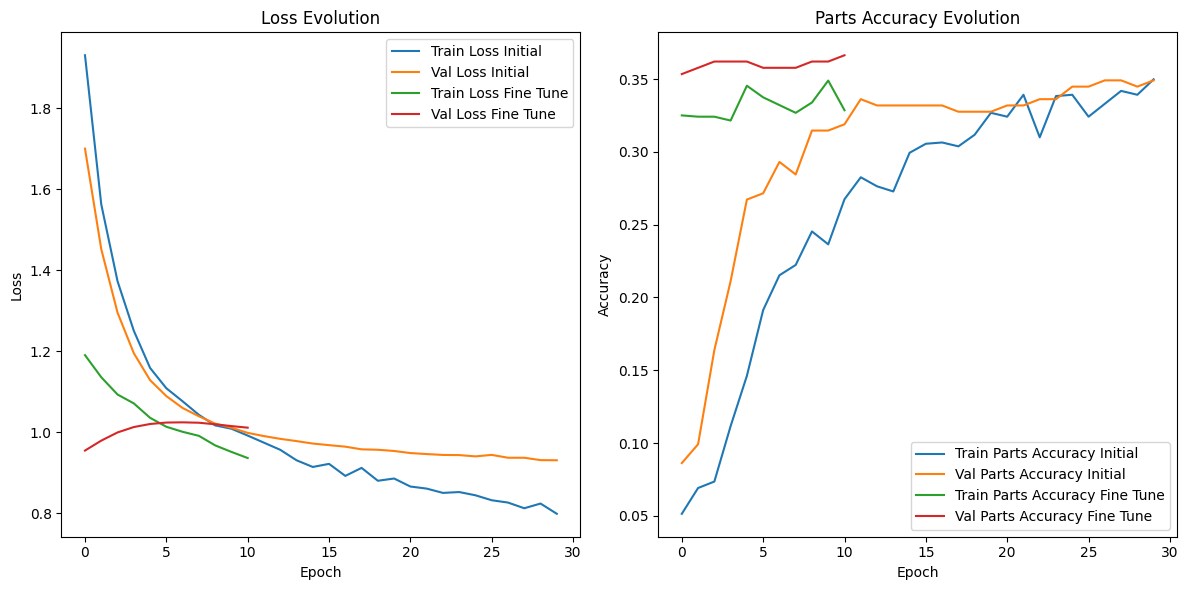

In [9]:
# Función para visualizar el historial de entrenamiento
def plot_training_history(history1, history2):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'], label='Train Loss Initial')
    plt.plot(history1.history['val_loss'], label='Val Loss Initial')
    plt.plot(history2.history['loss'], label='Train Loss Fine Tune')
    plt.plot(history2.history['val_loss'], label='Val Loss Fine Tune')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['partes_accuracy'], label='Train Parts Accuracy Initial')
    plt.plot(history1.history['val_partes_accuracy'], label='Val Parts Accuracy Initial')
    plt.plot(history2.history['partes_accuracy'], label='Train Parts Accuracy Fine Tune')
    plt.plot(history2.history['val_partes_accuracy'], label='Val Parts Accuracy Fine Tune')
    plt.title('Parts Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualizar resultados
plot_training_history(history_initial, history_fine_tune)

In [10]:
# =============================================
# EVALUACIÓN
# =============================================
def evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias):
    """Evalúa el modelo en el conjunto de prueba y muestra métricas"""
    # Evaluación general
    results = model.evaluate(test_generator, verbose=1)
    print(f"Pérdida total: {results[0]}")
    print(f"Pérdida partes: {results[1]} - Accuracy partes: {results[4]}")
    print(f"Pérdida daños: {results[2]} - Accuracy daños: {results[5]}")
    print(f"Pérdida sugerencias: {results[3]} - Accuracy sugerencias: {results[6]}")

    # Predicciones
    print("\nGenerando predicciones...")
    predictions = model.predict(test_generator, verbose=1)
    y_pred_partes = predictions[0] > 0.5
    y_pred_dannos = predictions[1] > 0.5
    y_pred_sugerencias = predictions[2] > 0.5

    # Obtener etiquetas verdaderas
    y_true_partes = test_generator.mlb_partes.transform(test_df['partes'])
    y_true_dannos = test_generator.mlb_dannos.transform(test_df['dannos'])
    y_true_sugerencias = test_generator.mlb_sugerencias.transform(test_df['sugerencias'])

    # Convertir IDs de clases a nombres
    def get_class_names(classes, label_dict):
        return [str(label_dict.get(int(cls), f"Clase_{cls}")) for cls in classes]

    partes_names = get_class_names(mlb_partes.classes_, label_to_cls_piezas)
    dannos_names = get_class_names(mlb_dannos.classes_, label_to_cls_danos)
    sugerencias_names = get_class_names(mlb_sugerencias.classes_, label_to_cls_sugerencias)

    # Reportes de clasificación
    print("\nReporte para Partes:")
    print(classification_report(
        y_true_partes,
        y_pred_partes,
        target_names=partes_names,
        zero_division=0
    ))

    print("\nReporte para Daños:")
    print(classification_report(
        y_true_dannos,
        y_pred_dannos,
        target_names=dannos_names,
        zero_division=0
    ))

    print("\nReporte para Sugerencias:")
    print(classification_report(
        y_true_sugerencias,
        y_pred_sugerencias,
        target_names=sugerencias_names,
        zero_division=0
    ))

    return {
        'results': results,
        'predictions': {
            'partes': y_pred_partes,
            'dannos': y_pred_dannos,
            'sugerencias': y_pred_sugerencias
        },
        'true_labels': {
            'partes': y_true_partes,
            'dannos': y_true_dannos,
            'sugerencias': y_true_sugerencias
        }
    }

# Realizar evaluación
evaluation_results = evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step - dannos_accuracy: 0.5609 - dannos_loss: 0.4009 - loss: 0.9733 - partes_accuracy: 0.3582 - partes_loss: 0.1926 - sugerencias_accuracy: 0.8736 - sugerencias_loss: 0.3806
Pérdida total: 0.9249882102012634
Pérdida partes: 0.18929921090602875 - Accuracy partes: 0.5983263850212097
Pérdida daños: 0.3831150531768799 - Accuracy daños: 0.36401674151420593
Pérdida sugerencias: 0.35615986585617065 - Accuracy sugerencias: 0.866108775138855

Generando predicciones...
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 584ms/step

Reporte para Partes:
                                  precision    recall  f1-score   support

                            Capó       0.67      0.12      0.21        16
          Espejo lateral derecho       0.00      0.00      0.00         2
                   Faros derecho       0.00      0.00      0.00        15
                 Faros izquierdo       0.00      0.00      0.00        14
  Guardabarros delantero derecho       0.00      0.00      0.00       

In [11]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES
# =============================================
def predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """Realiza predicciones para una nueva imagen"""
    # Cargar y preprocesar la imagen
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Hacer predicción
    predictions = model.predict(img_array)

    # Procesar resultados
    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    # Obtener las clases con mayor probabilidad (top 3 para cada categoría)
    top_partes = sorted(zip(mlb_partes.classes_, partes_probs), key=lambda x: x[1], reverse=True)[:3]
    top_dannos = sorted(zip(mlb_dannos.classes_, dannos_probs), key=lambda x: x[1], reverse=True)[:3]
    top_sugerencias = sorted(zip(mlb_sugerencias.classes_, sugerencias_probs), key=lambda x: x[1], reverse=True)[:3]

    # Convertir IDs a nombres
    def get_names(items, label_dict):
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in items]

    partes_nombres = get_names(top_partes, label_to_cls_piezas)
    dannos_nombres = get_names(top_dannos, label_to_cls_danos)
    sugerencias_nombres = get_names(top_sugerencias, label_to_cls_sugerencias)

    return {
        'partes': partes_nombres,
        'dannos': dannos_nombres,
        'sugerencias': sugerencias_nombres
    }

def print_predictions(prediction):
    print("\nPredicciones para la imagen:")
    for category, items in prediction.items():
        print(f"\n{category.capitalize()}:")
        if not items:
            print("- No se identificaron predicciones significativas")
        else:
            for name, prob in items:
                print(f"- {name}: {prob:.2%} de probabilidad")

In [12]:
# Ejemplo de uso
image_path = "../data/predecir/golpe_01.jpg"  # Asegúrate que esta ruta es correcta
prediction = predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)
print_predictions(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step

Predicciones para la imagen:

Partes:
- Rueda: 29.53% de probabilidad
- Clase_999: 26.29% de probabilidad
- Guardabarros trasero izquierdo: 24.28% de probabilidad

Dannos:
- Abolladura: 58.50% de probabilidad
- Rotura: 46.86% de probabilidad
- Rayón: 21.73% de probabilidad

Sugerencias:
- Reparar: 82.24% de probabilidad
- Reemplazar: 30.64% de probabilidad


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step

Predicciones para la imagen:

Partes:
- Rueda: 34.73% de probabilidad
- Guardabarros delantero izquierdo: 27.82% de probabilidad
- Parachoques delantero: 24.46% de probabilidad

Dannos:
- Abolladura: 54.11% de probabilidad
- Rotura: 42.21% de probabilidad
- Desprendimiento: 17.35% de probabilidad

Sugerencias:
- Reparar: 73.02% de probabilidad
- Reemplazar: 43.34% de probabilidad

In [13]:
# Ruta a la imagen de prueba
# image_path = "../data/predecir/golpe_01.jpg"
image_path = "../data/predecir/golpe_02.jpg"
# image_path = "../data/predecir/golpe_03.jpg"
# image_path = "../data/predecir/Siniestro_04.jpg"
# image_path = "../data/predecir/Siniestro_03.jpg"
# image_path = "../data/predecir/Siniestro_02.jpg"
# image_path = "../data/predecir/Siniestro_01.jpg"
# image_path = "../data/predecir/rayon_01.jpg"
# image_path = "../data/predecir/rayon_02.jpg"
# image_path = "../data/predecir/mica_rota_01.jpg"
# image_path = "../data/predecir/mica_rota-rayon_01.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


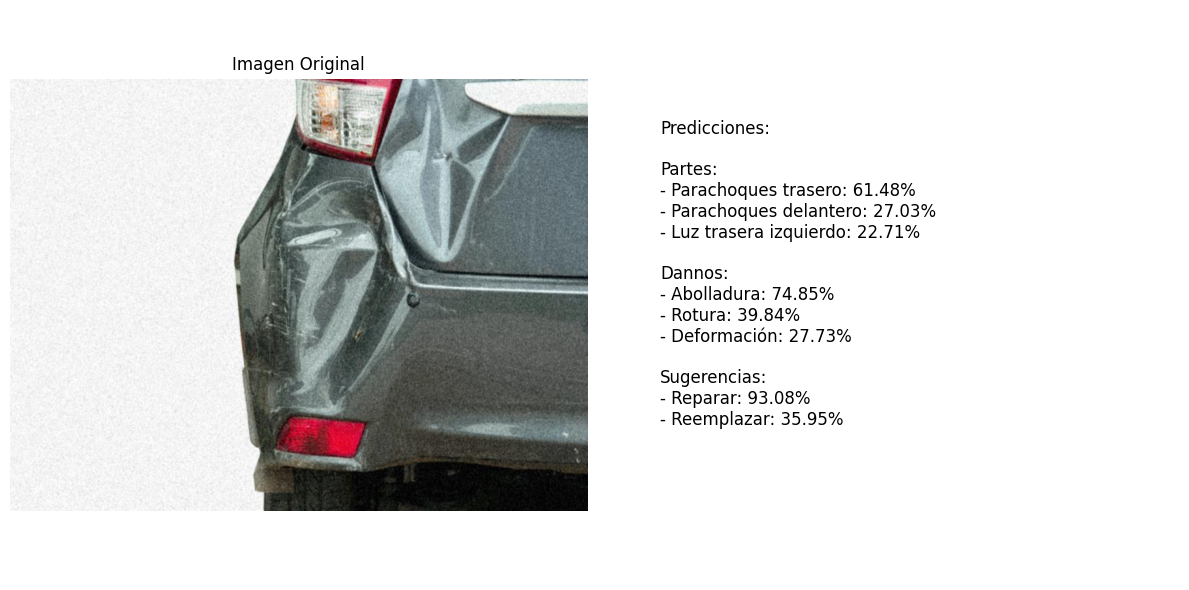

In [14]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES CON VISUALIZACIÓN
# =============================================
def predict_and_show(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """
    Realiza predicciones para una nueva imagen y la muestra junto con los resultados
    
    Args:
        image_path: Ruta a la imagen a predecir
        model: Modelo cargado para hacer predicciones
        mlb_partes: MultiLabelBinarizer para partes
        mlb_dannos: MultiLabelBinarizer para daños
        mlb_sugerencias: MultiLabelBinarizer para sugerencias
        img_size: Tamaño de la imagen para redimensionamiento
    """
    # Configurar el gráfico
    plt.figure(figsize=(12, 6))
    
    # 1. Mostrar la imagen original
    img = tf.keras.preprocessing.image.load_img(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen Original")
    plt.axis('off')
    
    # 2. Preprocesar la imagen para el modelo
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.resize(img_array, img_size)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    # 3. Hacer predicción
    predictions = model.predict(img_array)
    
    # 4. Procesar resultados
    def get_top_predictions(classes, probs, label_dict, top_n=3):
        """Obtiene las top N predicciones con sus nombres y probabilidades"""
        top_items = sorted(zip(classes, probs[0]), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]
    
    resultados = {
        'partes': get_top_predictions(mlb_partes.classes_, predictions[0], label_to_cls_piezas),
        'dannos': get_top_predictions(mlb_dannos.classes_, predictions[1], label_to_cls_danos),
        'sugerencias': get_top_predictions(mlb_sugerencias.classes_, predictions[2], label_to_cls_sugerencias)
    }
    
    # 5. Mostrar resultados
    plt.subplot(1, 2, 2)
    text_content = "Predicciones:\n\n"
    
    for category, items in resultados.items():
        text_content += f"{category.capitalize()}:\n"
        if not items:
            text_content += "- No se identificaron predicciones significativas\n"
        else:
            for name, prob in items:
                text_content += f"- {name}: {prob:.2%}\n"
        text_content += "\n"
    
    plt.text(0.1, 0.5, text_content, fontsize=12, va='center')
    plt.axis('off')
    plt.tight_layout()
    
    # Mostrar todo
    plt.show()
    
    return resultados

# Visualización y predicción ejemplo
resultados = predict_and_show(
    image_path=image_path,
    model=model,
    mlb_partes=mlb_partes,
    mlb_dannos=mlb_dannos,
    mlb_sugerencias=mlb_sugerencias
)

In [15]:
# Guardar resultados
def save_evaluation_results(results, filename='evaluation_results_fine_tuning.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

Resultados guardados en evaluation_results_fine_tuning.json


In [16]:
# =============================================
# GUARDAR RESULTADOS
# =============================================
def save_evaluation_results(results, filename='evaluation_results_fine_tuning_v2.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

Resultados guardados en evaluation_results_fine_tuning_v2.json


---
cargar el modelo ya entrenado

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import applications
import os

# Diccionarios de mapeo (debe adaptarse si se usan otros)
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

def load_model(model_path):
    """
    Carga un modelo guardado en formato .keras o .h5 sin necesidad de reentrenar.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"El archivo del modelo no existe: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print(f"Modelo cargado desde {model_path}")
    return model

def preprocess_image(image_path, img_size=(224, 224)):
    """
    Carga y preprocesa una imagen para la predicción.
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict(image_path, model, mlb_partes, mlb_danos, mlb_sugerencias):
    """
    Realiza predicción usando el modelo cargado para una imagen dada.
    """
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)

    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    def get_top_predictions(classes, probs, label_dict, top_n=3):
        top_items = sorted(zip(classes, probs), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]

    partes_pred = get_top_predictions(mlb_partes.classes_, partes_probs, label_to_cls_piezas)
    dannos_pred = get_top_predictions(mlb_danos.classes_, dannos_probs, label_to_cls_danos)
    sugerencias_pred = get_top_predictions(mlb_sugerencias.classes_, sugerencias_probs, label_to_cls_sugerencias)

    return {
        'partes': partes_pred,
        'dannos': dannos_pred,
        'sugerencias': sugerencias_pred
    }

In [26]:
# Ejemplo de uso (adaptar mlb_* según su entorno)
if __name__ == "__main__":
    import pickle

    # Cargar modelo
    model_path = "final_model_fine_tuned_v2.keras"  # Cambiar si se usa otro archivo
    model = load_model(model_path)

    # Cargar MultiLabelBinarizer guardados (adaptar rutas)
    with open("mlb_partes.pkl", "rb") as f:
        mlb_partes = pickle.load(f)
    with open("mlb_dannos.pkl", "rb") as f:
        mlb_dannos = pickle.load(f)
    with open("mlb_sugerencias.pkl", "rb") as f:
        mlb_sugerencias = pickle.load(f)

Modelo cargado desde final_model_fine_tuned_v2.keras


In [27]:
# Ruta imagen para predecir
image_path = "../data/predecir/golpe_01.jpg"

In [28]:
# Realizar predicción
prediction = predict(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)

print("Predicciones:")
for category, preds in prediction.items():
    print(f"\n{category.capitalize()}:")
    for name, prob in preds:
        print(f"- {name}: {prob:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
Predicciones:

Partes:
- Rueda: 34.73%
- Guardabarros delantero izquierdo: 27.82%
- Parachoques delantero: 24.46%

Dannos:
- Abolladura: 54.11%
- Rotura: 42.21%
- Desprendimiento: 17.35%

Sugerencias:
- Reparar: 73.02%
- Reemplazar: 43.34%


---